In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
lower = 120
upper = 180
start = 0

In [3]:
dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
# применим смещение, чтобы выровнять сигнал
dataset = (dataset.pipe(lambda x: 2**14 - x - 1560))
data = dataset.loc[start:, lower:upper]

signals = dataset.iloc[:, :].values

In [4]:
def extract_features(signal):
    features = {}
    integral = []
    signal = np.array(signal)  # Преобразуем в numpy array
    
    # Базовые характеристики
    baseline = np.median(signal[:10])  # Базовый уровень (первые 10 точек)
    signal_corrected = signal - baseline  # Корректировка базовой линии
    
    # Амплитуда (максимальное отклонение от baseline, с учетом знака)
    max_amplitude = np.max(signal_corrected)
    min_amplitude = np.min(signal_corrected)
    features['amplitude'] = max_amplitude if abs(max_amplitude) > abs(min_amplitude) else min_amplitude

    # Площадь сигнала
    features['absolute_area'] = np.sum(np.abs(signal_corrected))
    integral = np.sum(signal_corrected)
    features['baseline'] = baseline
    
    # Время нарастания (10% до 90% амплитуды)
    max_val = features['amplitude']
    if max_val > 0:  # Защита от деления на 0
        time_10 = np.where(signal_corrected >= 0.1 * max_val)[0]
        time_90 = np.where(signal_corrected >= 0.9 * max_val)[0]
        
        if len(time_10) > 0 and len(time_90) > 0:
            features['rise_time'] = time_90[0] - time_10[0]
        else:
            features['rise_time'] = 0
    else:
        features['rise_time'] = 0
    
    # Время спада (90% до 10% амплитуды на спаде)
    peak_pos = np.argmax(signal_corrected)
    tail_signal = signal_corrected[peak_pos:]
    
    if max_val > 0:
        time_90_decay = np.where(tail_signal <= 0.9 * max_val)[0]
        time_10_decay = np.where(tail_signal <= 0.1 * max_val)[0]
        
        if len(time_90_decay) > 0 and len(time_10_decay) > 0:
            features['decay_time'] = time_10_decay[0] - time_90_decay[0]
        else:
            features['decay_time'] = 0
    else:
        features['decay_time'] = 0
    
    # Параметр PSD (Pulse Shape Discrimination)
    features['psd'] = integral / features['amplitude'] if features['amplitude'] > 0 else 0
    
    # Дополнительные параметры
    features['kurtosis'] = pd.Series(signal_corrected).kurtosis()
    
    return features

**Амплитуда** (`amplitude`) — максимальное значение сигнала.  
**Площадь сигнала** (`absolute_area`) — сумма абсолютных значений.  
**Базовый уровень** (`baseline`) — фоновое значение сигнала.  
**Время нарастания** (`rise_time`) — как быстро сигнал достигает пика.  
**Время спада** (`decay_time`) — как быстро сигнал возвращается к базовой линии.  
**Спектр мощности** (`psd`) — распределение энергии по частотам.  
**Острота пика** (`kurtosis`) — насколько сигнал "островершинный".  

In [5]:
# Извлечение признаков для всех сигналов
features_list = []
for signal in signals:
    features_list.append(extract_features(signal))

features_df = pd.DataFrame(features_list)

# Удаление возможных NaN или inf значений
features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_df.dropna(inplace=True)
features_df

,amplitude,absolute_area,baseline,rise_time,decay_time,psd,kurtosis
0,530.0,5325.0,3.0,3,10,8.583019,73.983010
1,1901.0,12879.0,2.0,2,7,6.371910,85.801618
2,2558.5,17711.0,1.5,3,7,6.740278,84.307518
3,564.0,5284.0,2.0,2,8,7.585106,77.168438
4,1794.0,12501.0,2.0,3,7,6.628205,83.897228
...,...,...,...,...,...,...,...
23474,505.0,4455.0,-1.0,2,7,7.423762,82.264733
23475,5766.5,45819.0,0.5,3,8,7.891962,78.858213
23476,4998.0,39337.0,1.0,3,9,7.792517,80.550306
23477,1456.5,12970.0,0.5,3,9,8.639204,77.800549


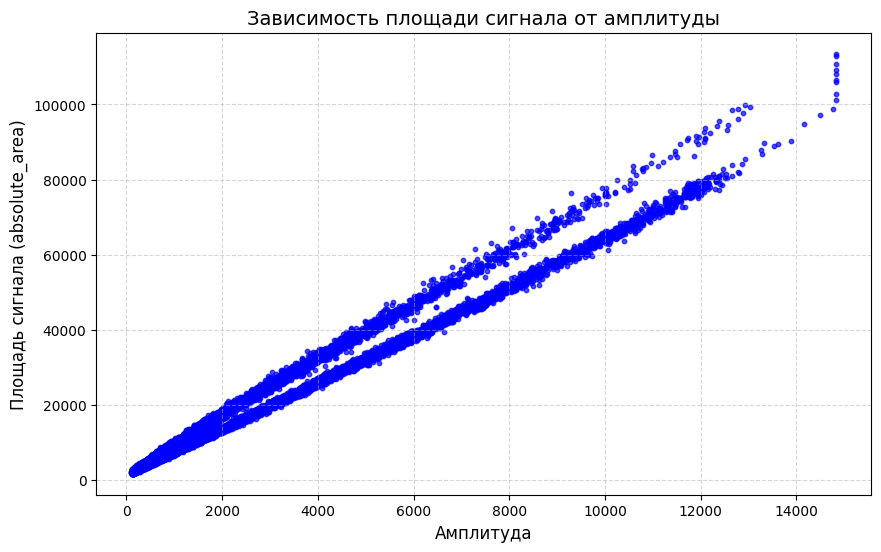

In [6]:
# Собираем амплитуды и площади
amplitudes = [f['amplitude'] for f in features_list]
absolute_areas = [f['absolute_area'] for f in features_list]

# Строим график
plt.figure(figsize=(10, 6))
plt.scatter(amplitudes, absolute_areas, color='blue', s=10, alpha=0.7)
plt.title('Зависимость площади сигнала от амплитуды', fontsize=14)
plt.xlabel('Амплитуда', fontsize=12)
plt.ylabel('Площадь сигнала (absolute_area)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

In [7]:
# Масштабирование признаков
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Применение PCA для визуализации
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture

# Выделение аномалий (сохранение имен переменных как в исходном коде)
iso_forest = IsolationForest(contamination=0.0094, random_state=42)
anomalies = iso_forest.fit_predict(scaled_features)
normal_data = scaled_features[anomalies == 1]

# Кластеризация нормальных данных с помощью BIRCH
model = Birch(threshold=0.03759, n_clusters=2)
labels_normal = model.fit_predict(normal_data)

# Замените KMeans на Gaussian Mixture
# model = GaussianMixture(n_components=2,  random_state=42)
# labels_normal = model.fit_predict(normal_data)

# model = AgglomerativeClustering(n_clusters=2, linkage='complete')
# labels_normal = model.fit_predict(normal_data)

# max_indices = np.argsort(normal_data.sum(axis=1))[-2:]  # для 2 кластеров
# initial_centroids = normal_data[max_indices]
# # Кластеризация нормальных данных (с улучшенными параметрами, но сохранением структуры)
# model = KMeans(n_clusters=2, init='random', n_init=50, max_iter=300, tol=0.03, random_state=42)
# labels_normal = model.fit_predict(normal_data)

# Создание полного массива меток
labels = np.full(scaled_features.shape[0], 2)
labels[anomalies == 1] = labels_normal
# centroids = model.cluster_centers_
features_df['cluster'] = labels 
silhouette_avg = silhouette_score(normal_data, labels_normal)
ch_score = calinski_harabasz_score(normal_data, labels_normal)
db_score = davies_bouldin_score(normal_data, labels_normal)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.1f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
features_df


Silhouette Score: 0.296
Calinski-Harabasz Index: 8177.4
Davies-Bouldin Index: 1.356


,amplitude,absolute_area,baseline,rise_time,decay_time,psd,kurtosis,cluster
0,530.0,5325.0,3.0,3,10,8.583019,73.983010,1
1,1901.0,12879.0,2.0,2,7,6.371910,85.801618,0
2,2558.5,17711.0,1.5,3,7,6.740278,84.307518,0
3,564.0,5284.0,2.0,2,8,7.585106,77.168438,0
4,1794.0,12501.0,2.0,3,7,6.628205,83.897228,0
...,...,...,...,...,...,...,...,...
23474,505.0,4455.0,-1.0,2,7,7.423762,82.264733,0
23475,5766.5,45819.0,0.5,3,8,7.891962,78.858213,0
23476,4998.0,39337.0,1.0,3,9,7.792517,80.550306,1
23477,1456.5,12970.0,0.5,3,9,8.639204,77.800549,1


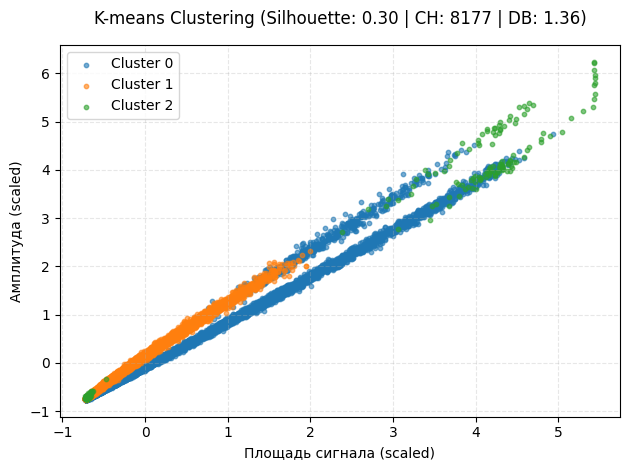

In [286]:
# Разделяем точки по кластерам
for i in range(3):
    cluster_points = scaled_features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f'Cluster {i}', alpha=0.6, s=10)

# # Отмечаем центроиды
# plt.scatter(centroids[:, 0], centroids[:, 1], 
#             marker='X', s=200, c='black', 
#             label='Centroids', edgecolors='w', linewidths=1)

# # Добавляем разделительную линию
# mid_point = (centroids[0] + centroids[1]) / 2 
# direction = centroids[1] - centroids[0]       
# slope = -direction[0] / direction[1]

# # Рисуем линию через середину (удлиняем до границ графика)
# x_vals = np.array(plt.xlim())
# y_vals = mid_point[1] + slope * (x_vals - mid_point[0])
# plt.plot(x_vals, y_vals, 'k--', linewidth=1, alpha=0.5)  # 'k--' = чёрная пунктирная

# Добавляем метрики в заголовок
plt.title(f'K-means Clustering (Silhouette: {silhouette_avg:.2f} | CH: {ch_score:.0f} | DB: {db_score:.2f})',
          pad=15)

plt.xlabel('Площадь сигнала (scaled)')
plt.ylabel('Амплитуда (scaled)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

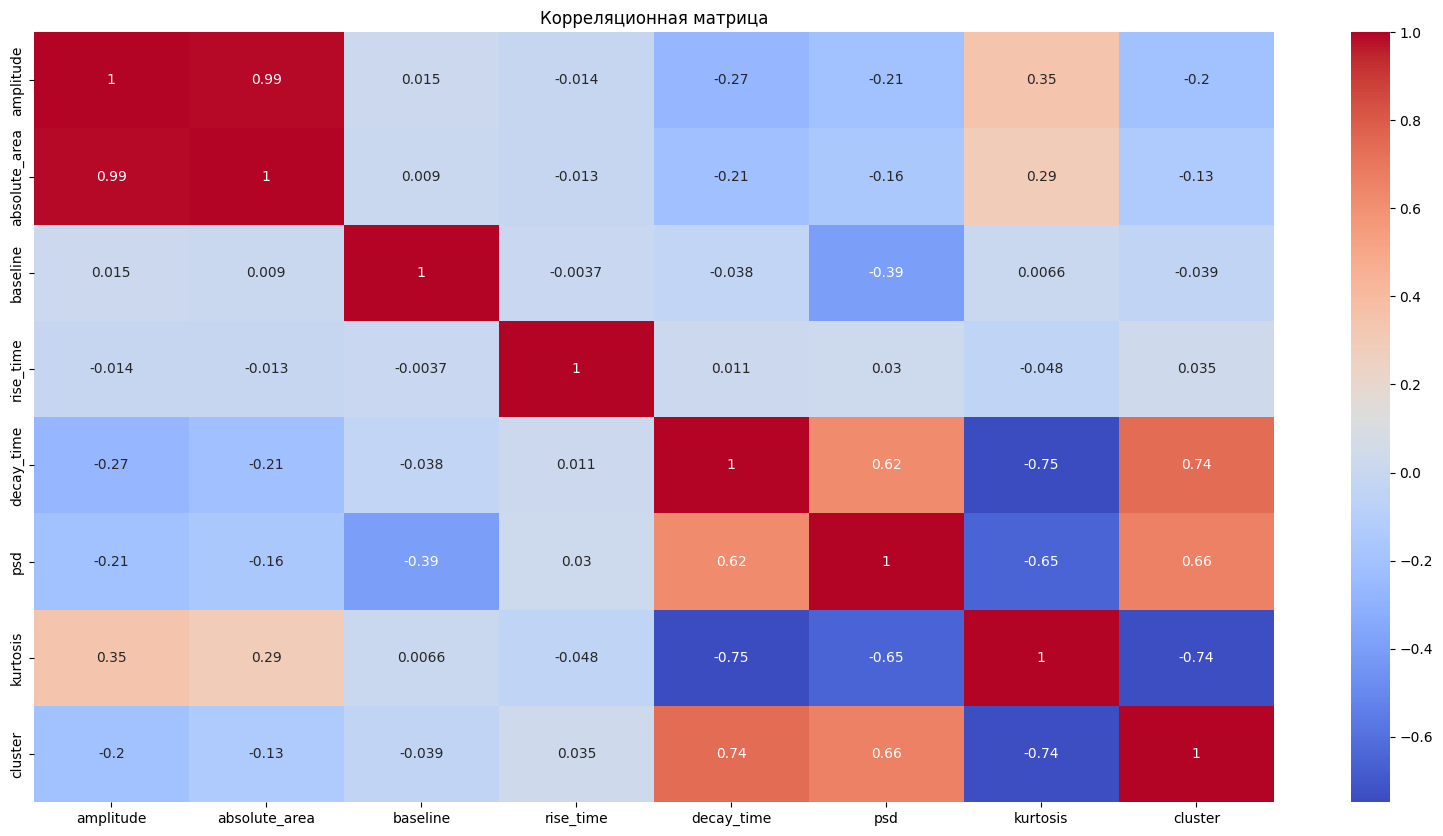

In [287]:

plt.figure(figsize = (20, 10))
sns.heatmap(features_df.corr(), annot = True, cmap = "coolwarm")
plt.title("Корреляционная матрица")
plt.show()

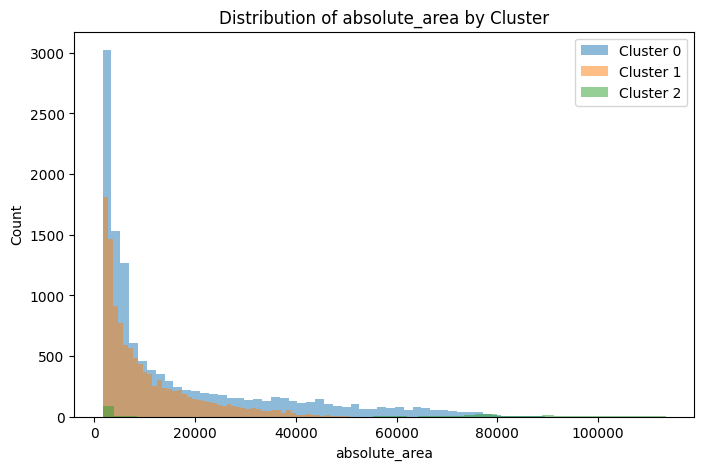

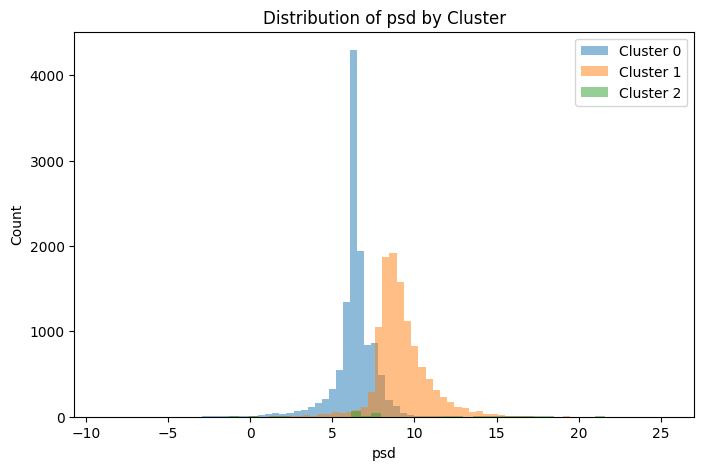

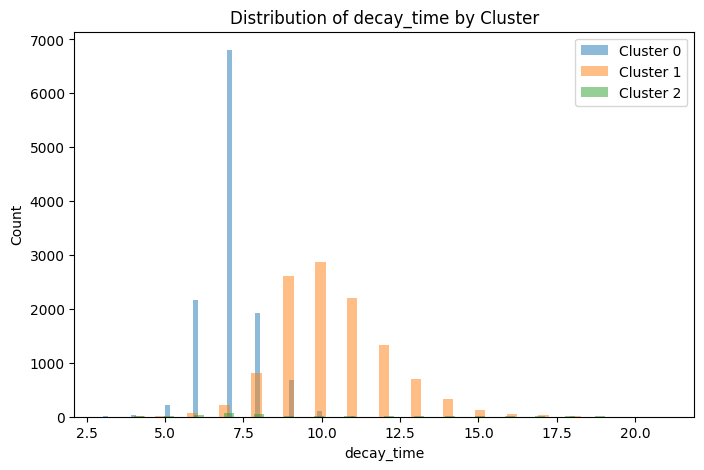

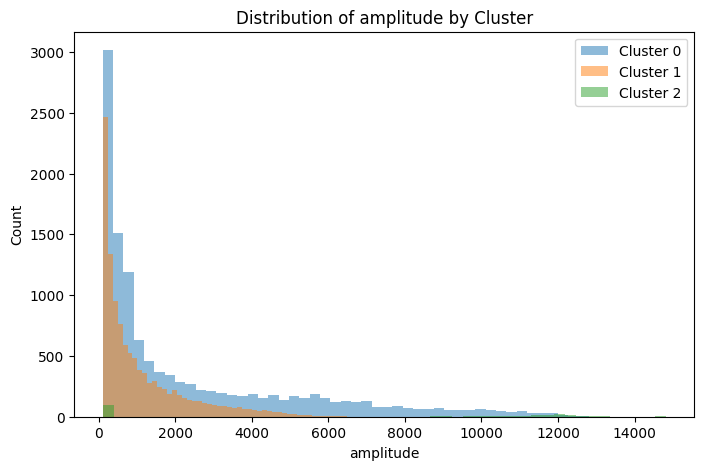

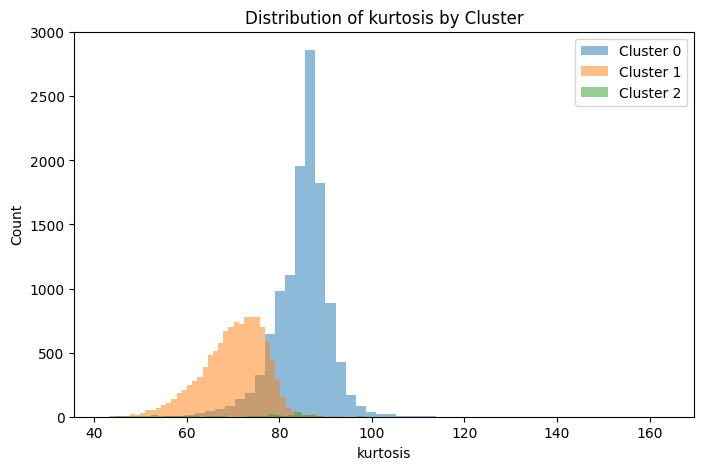

In [288]:
# Анализ распределения ключевых признаков по кластерам
for feature in ['absolute_area', 'psd', 'decay_time', 'amplitude', 'kurtosis']:
    plt.figure(figsize=(8, 5))
    for cluster in sorted(features_df['cluster'].unique()):
        subset = features_df[features_df['cluster'] == cluster]
        plt.hist(subset[feature], bins=50, alpha=0.5, label=f'Cluster {cluster}')
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [289]:
# Инвертируем классы 0 и 1
results = pd.DataFrame({
    'Index': range(len(labels)),
    'cluster': labels
})

# # Заменяем 0 на 1 и 1 на 0
results['cluster'] = results['cluster'].map({0: '1', 1: '0'})

# Сохраняем результаты
results.to_csv('clustering_results.csv', index=False)

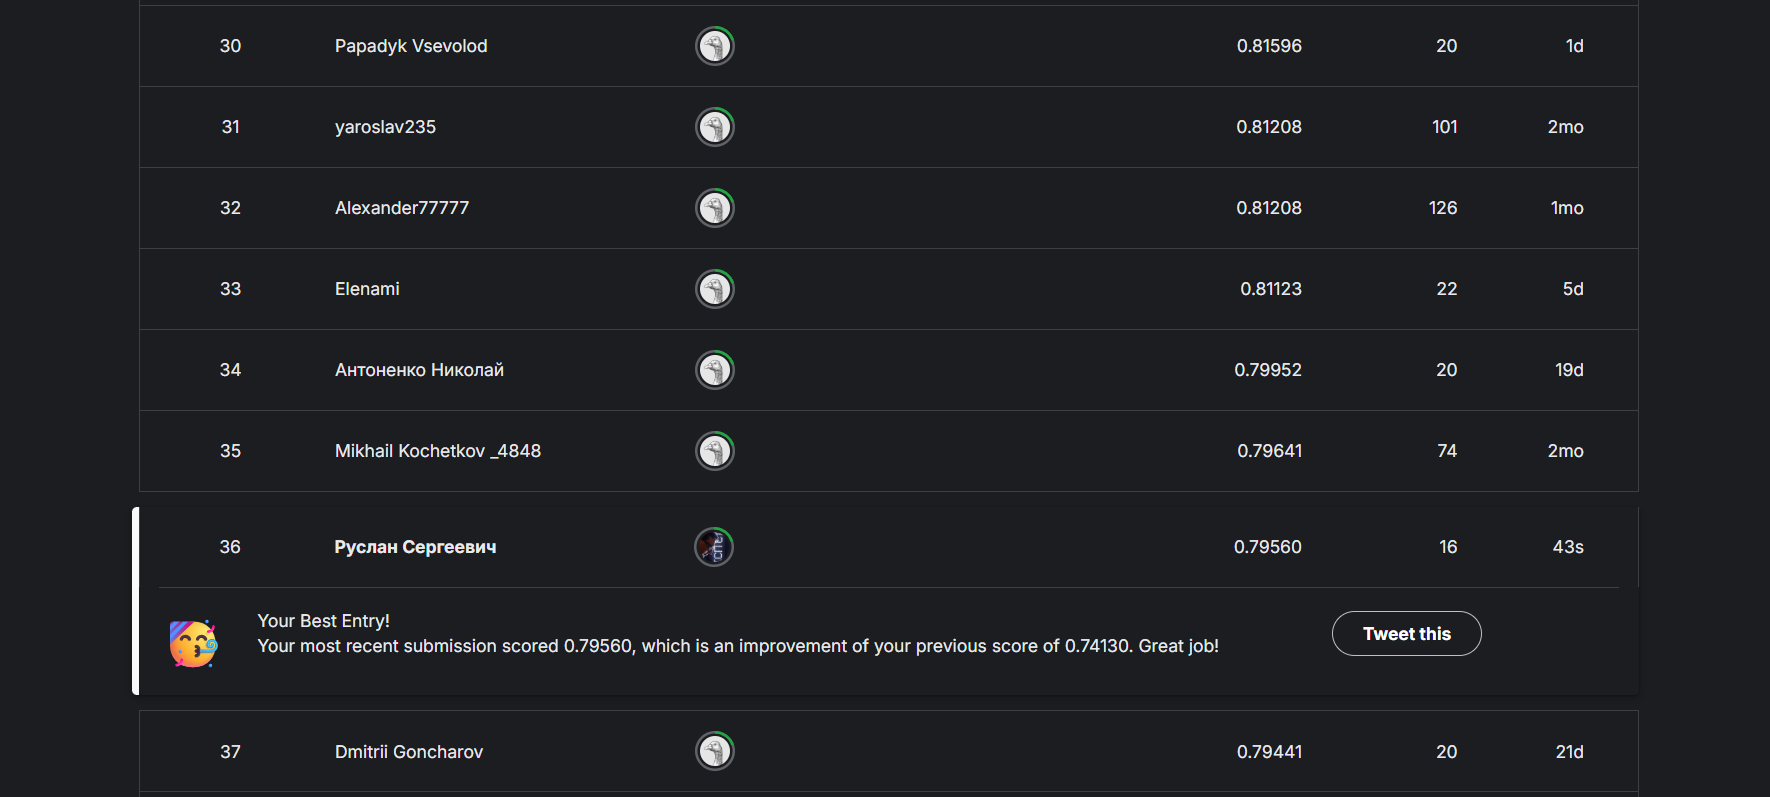
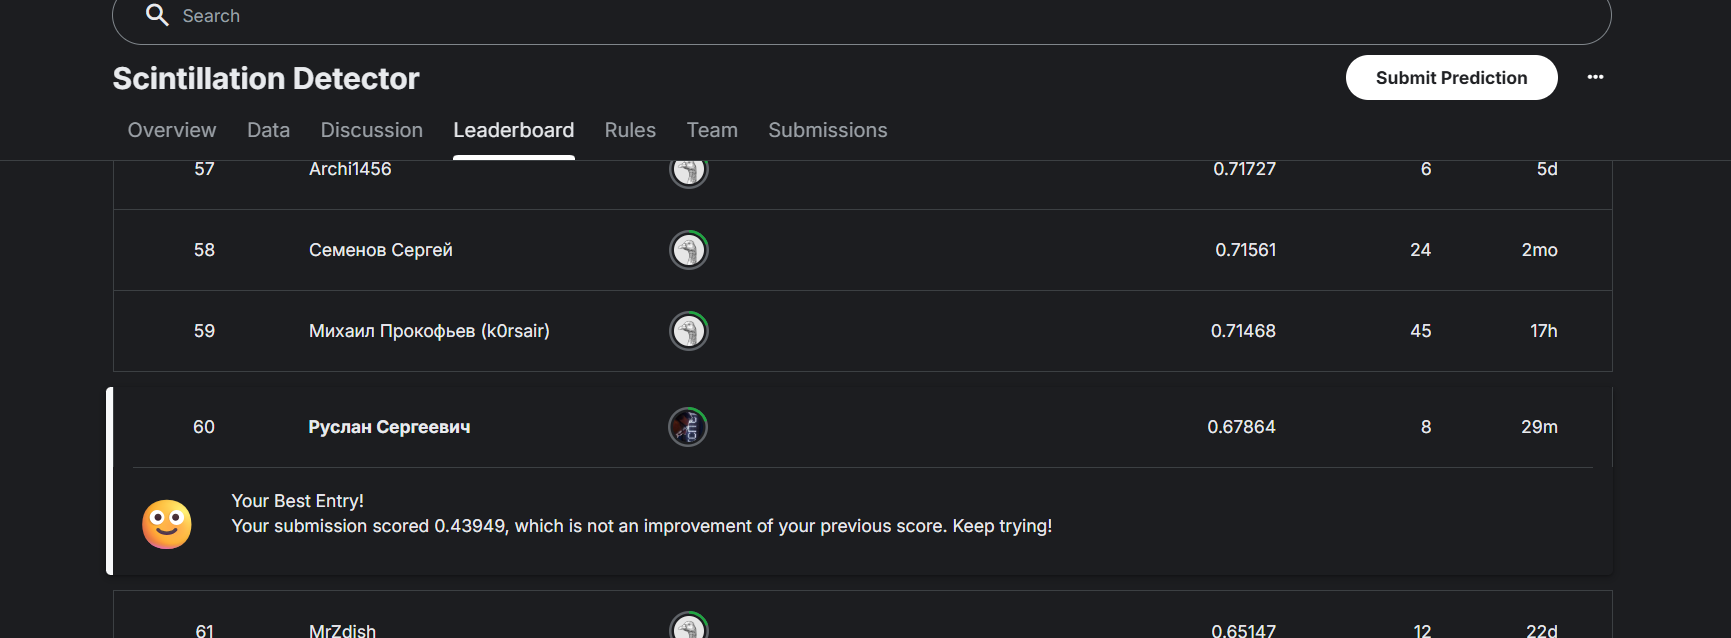